### TensorFlow GNN model

#### preprocessing

In [16]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("robot_kinematics_dataset.csv")

# Separate input (angles) and output (position)
X = df[["q1","q2","q3","q4","q5","q6"]].values   # shape: [N_samples, 6]
y = df[["x","y","z"]].values                     # shape: [N_samples, 3]

# Reshape input into node features: [N_samples, 6, 1]
X_nodes = X.reshape(-1, 6, 1)
print(len(df))


15000


#### TF Model

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [67]:
# --- 1) Split (fixed)
np.random.seed(42)
N = len(df)
idx = np.random.permutation(N)
n_tr = int(0.7*N); n_va = int(0.15*N)
tr, va, te = idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

Xtr, Xva, Xte = X[tr], X[va], X[te]
ytr, yva, yte = y[tr], y[va], y[te]



Xtr = Xtr.reshape(-1, 6, 1); Xva = Xva.reshape(-1, 6, 1); Xte = Xte.reshape(-1, 6, 1)

print(len(Xtr))
print(Xtr.shape)
# --- 3) Graph (chain + self loops) -> symmetric norm
Nn = 6
A = np.zeros((Nn,Nn), np.float32)
for i in range(Nn-1):
    A[i,i+1] = A[i+1,i] = 1.0
A += np.eye(Nn, dtype=np.float32)
deg = np.sum(A, axis=1)
Dmh = np.diag(1.0/np.sqrt(deg + 1e-8)).astype(np.float32)
A_hat = tf.constant(Dmh @ A @ Dmh, tf.float32)   # [6,6]


10500
(10500, 6, 1)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 6, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_gcn_block      │ (None, 6, 32)     │        160 │ input_layer_22[0… │
│ (DeepGCNBlock)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_gcn_block_1    │ (None, 6, 32)     │      1,120 │ deep_gcn_block[0… │
│ (DeepGCNBlock)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_gcn_block_2    │ (None, 6, 32)     │      1,120 │ deep_gcn_block_1… │
│ (DeepGCNBlock)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ deep_gcn_block_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ deep_gcn_block_2… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │      4,160 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 3)         │         99 │ dense_39[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,739 (34.14 KB)

 Trainable params: 8,739 (34.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1049 - mae: 0.2368  [VAL RMSE raw] x:0.1221, y:0.1107, z:0.1215
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0558 - mae: 0.1726 - val_loss: 0.0140 - val_mae: 0.0969 - learning_rate: 0.0010
Epoch 2/200
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - mae: 0.1099  [VAL RMSE raw] x:0.1034, y:0.1018, z:0.1105
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - mae: 0.1032 - val_loss: 0.0111 - val_mae: 0.0870 - learning_rate: 0.0010
Epoch 3/200
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - mae: 0.0939  [VAL RMSE raw] x:0.1001, y:0.0998, z:0.1087
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - mae: 0.0928 - val_loss: 0.0106 - val_mae: 0.0853 - learning_rate: 0.0010
Epoch 4/200
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - mae: 0.0902  [VAL RMSE raw] x:0.0992, y:0.0990, z:0.1026
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - mae: 0.0886 - val_loss: 0.0101 - val_mae: 0.0831 - learn

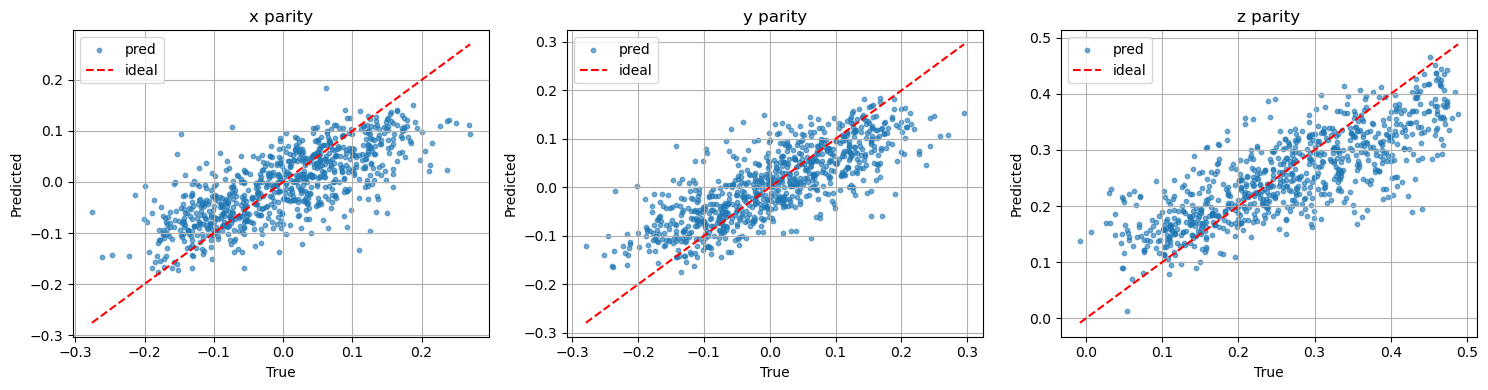

In [69]:

# --- Deeper GCN block with residual + norm + dropout
class DeepGCNBlock(layers.Layer):
    def __init__(self, out_dim, pdrop=0.1, activation="relu"):
        super().__init__()
        self.out_dim = out_dim
        self.pdrop = pdrop
        self.act = tf.keras.activations.get(activation)
        self.norm = layers.LayerNormalization(axis=-1, epsilon=1e-6)
        self.drop = layers.Dropout(pdrop)

    def build(self, input_shape):
        in_dim = int(input_shape[-1])
        # weight + bias for graph conv
        self.W = self.add_weight(shape=(in_dim, self.out_dim),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(self.out_dim,), initializer="zeros", trainable=True)
        # 1x1 projection if dimensions change (for residual)
        self.proj = None
        if in_dim != self.out_dim:
            self.proj = self.add_weight(shape=(in_dim, self.out_dim),
                                        initializer="glorot_uniform", trainable=True)

    def call(self, X, training=False):  # X: [B,N,Fin]
        # Graph conv
        XW = tf.tensordot(X, self.W, axes=[2,0]) + self.b   # [B,N,Fout]
        GX = tf.einsum('ij,bjf->bif', A_hat, XW)            # [B,N,Fout]
        GX = self.act(GX)
        GX = self.drop(GX, training=training)

        # Residual (with projection if needed)
        if self.proj is not None:
            X = tf.tensordot(X, self.proj, axes=[2,0])
        Y = GX + X

        # Post-norm
        Y = self.norm(Y)
        return Y

# --- Build deeper model
inp  = layers.Input(shape=(Nn,1))  # (6,1) per sample
g1   = DeepGCNBlock(32, pdrop=0.05)(inp)
g2   = DeepGCNBlock(32, pdrop=0.05)(g1)
g3   = DeepGCNBlock(32, pdrop=0.05)(g2)

# Readout
gap  = layers.GlobalAveragePooling1D()(g3)
gmp  = layers.GlobalMaxPooling1D()(g3)
read = layers.Concatenate()([gap, gmp])  # [B, 64]

# MLP head
h1   = layers.Dense(64, activation="relu")(read)
h1   = layers.Dropout(0.1)(h1)
h2   = layers.Dense(32, activation="relu")(h1)
out  = layers.Dense(3)(h2)  # RAW xyz

model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()


# --- 5) Data
BATCH=256
train_ds = tf.data.Dataset.from_tensor_slices((Xtr, ytr)).shuffle(4096).batch(BATCH).prefetch(2)
val_ds   = tf.data.Dataset.from_tensor_slices((Xva, yva)).batch(BATCH).prefetch(2)
test_ds  = tf.data.Dataset.from_tensor_slices((Xte, yte)).batch(BATCH)

# --- 6) Callback printing RMSE in RAW units
class RawRMSE(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        yp = self.model.predict(val_ds, verbose=0)
        yt = np.concatenate([y for _, y in val_ds], axis=0)
        rmse = np.sqrt(np.mean((yp - yt)**2, axis=0))
        print(f"  [VAL RMSE raw] x:{rmse[0]:.4f}, y:{rmse[1]:.4f}, z:{rmse[2]:.4f}")

cbs = [
    RawRMSE(),
    tf.keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5, verbose=1, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
]

# --- 7) Train
history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=cbs, verbose=1)

# --- 8) Evaluate (RAW)
y_pred = model.predict(test_ds, verbose=0)
y_true = np.concatenate([y for _, y in test_ds], axis=0)
rmse = np.sqrt(np.mean((y_pred - y_true)**2, axis=0))
mae  = np.mean(np.abs(y_pred - y_true), axis=0)
print("TEST RMSE [x,y,z] (raw):", rmse, " Overall:", rmse.mean())
print("TEST  MAE [x,y,z] (raw):", mae,  " Overall:", mae.mean())

# --- 9) Parity plots (RAW)
import matplotlib.pyplot as plt
labels = ['x','y','z']; m = min(800, len(y_true)); idxs = np.random.choice(len(y_true), m, replace=False)
fig, axs = plt.subplots(1,3, figsize=(15,4))
for i in range(3):
    t, p = y_true[idxs, i], y_pred[idxs, i]
    axs[i].scatter(t, p, s=10, alpha=0.6, label='pred')
    lo, hi = t.min(), t.max(); axs[i].plot([lo, hi], [lo, hi], 'r--', label='ideal')
    axs[i].set_title(f"{labels[i]} parity")
    axs[i].set_xlabel("True"); axs[i].set_ylabel("Predicted"); axs[i].grid(True); axs[i].legend()
plt.tight_layout(); plt.show()